# Facial Emotion Recognition using AffectNet dataset with PyTorch

### Notebook 01

This notebook is to carry out EDA on the AffectNet dataset



In [1]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset, Subset
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from pathlib import Path
import os
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
%pwd

'/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch/notebooks'

In [3]:
proj_dir = Path('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch')

In [4]:
# create path variable for data directory
data_dir = Path(proj_dir / 'data_new')
data_dir

PosixPath('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch/data_new')

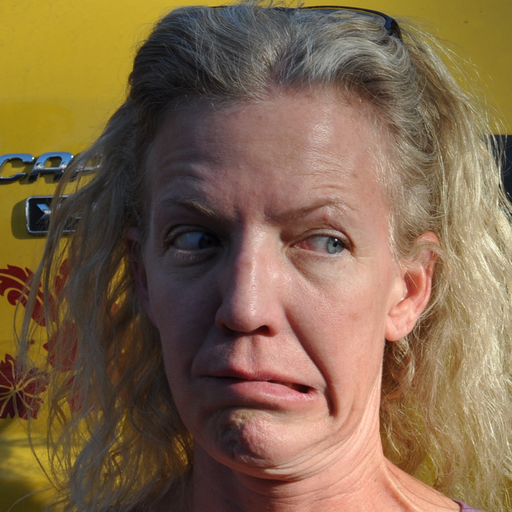

In [5]:
# Display a random image
with open(Path(data_dir, 'sad', 'ffhq_3.png'), 'rb') as file:
  image = Image.open(file)
  display(image)


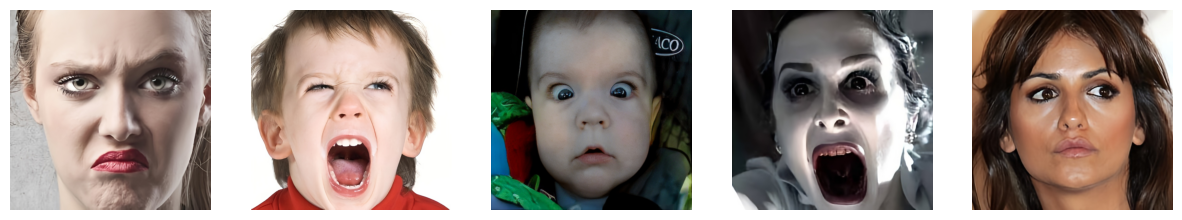

In [6]:
# get the image files
image_files = list(data_dir.glob( "**/*.jpg"))

# Randomly select 5 images
selected_images = random.sample(image_files, 5)

# Plot the images
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(selected_images):
    plt.subplot(1, 5, i+1)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis("off")

plt.show()


In [7]:
# Create transformation and load dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
sample_images, sample_labels = next(iter(dataloader))

In [9]:
# Check the shape of a sample random image
sample_images[0].shape

torch.Size([3, 224, 224])

In [26]:
# Check a random label
sample_labels[1]

tensor(3)

In [11]:
# Explore classes in dataset
classes = dataset.classes
classes

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
# Class to indices
class_to_idx = dataset.class_to_idx
class_to_idx

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [13]:
# Create a idx_to_class dictionary
idx_to_class = {value:key for key, value in class_to_idx.items()}
idx_to_class

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

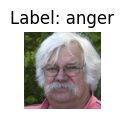

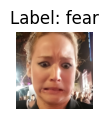

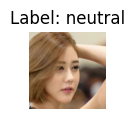

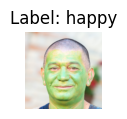

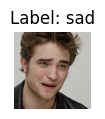

In [14]:
# Display 5 sample images with their labels
for i in range(5):
    plt.figure(figsize=(2, 1))
    plt.imshow(sample_images[i].permute(1, 2, 0))    # Convert PyTorch tensor to correct format
    plt.title(f"Label: {idx_to_class[sample_labels[i].item()]}")
    plt.axis("off")

    plt.show()

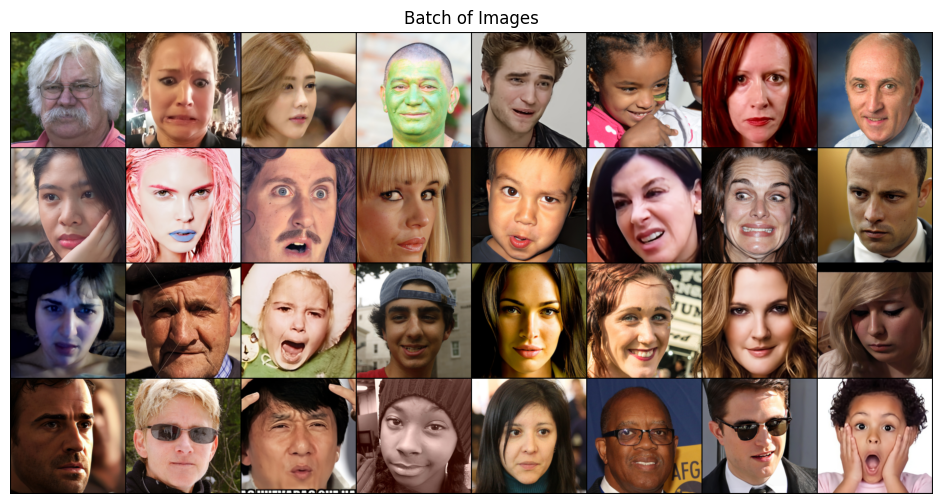

In [15]:

grid_image = make_grid(sample_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(12, 6))
plt.imshow(grid_image.permute(1, 2, 0))
plt.axis("off")
plt.title("Batch of Images")
plt.show()


In [16]:
# We would split the dataset to train and validation set
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [17]:
# We will split the validation to validation and test set
val_dataset, test_dataset = random_split(val_dataset, [0.5, 0.5], generator=g)

In [18]:
train_length = len(train_dataset)
val_length = len(val_dataset)
test_length = len(test_dataset)
total_length = len(dataset)

print(f"Train length: {train_length}, {train_length/total_length:.2%}")
print(f"Validation length: {val_length}, {val_length/total_length:.2%}")
print(f"Test length: {test_length}, {test_length/total_length:.2%}")
print(f"Total length: {total_length}")

Train length: 24555, 80.00%
Validation length: 3069, 10.00%
Test length: 3069, 10.00%
Total length: 30693


In [19]:
# Set batch size
batch_size = 32

In [20]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

# Check class balance

In [35]:
class_counts = Counter([idx_to_class[label.item()] for batch in tqdm(train_dataloader) for label in batch[1]])
print("Class distribution:", class_counts)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [01:20<00:00,  9.50it/s]

Class distribution: Counter({'surprise': 3831, 'happy': 3489, 'anger': 3322, 'fear': 2997, 'disgust': 2985, 'contempt': 2792, 'sad': 2662, 'neutral': 2477})


In [36]:
class_counts


Counter({'surprise': 3831,
         'happy': 3489,
         'anger': 3322,
         'fear': 2997,
         'disgust': 2985,
         'contempt': 2792,
         'sad': 2662,
         'neutral': 2477})

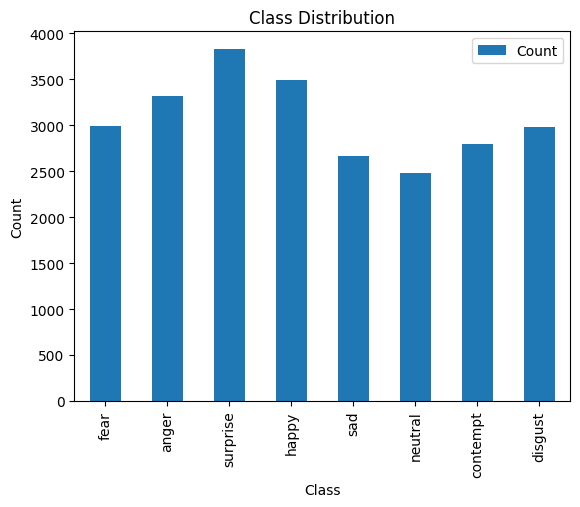

In [37]:
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

The chart above reveals a class imbalance problem. This imbalance can lead toa biased model that would perform poorly on the underrepresented classes.

To deal with this issue we have the following options:

1. **Data augmentation** - Generate additional data from the underrepresented class by roration, flipping, cropping ot colour jittering. GANs can also be used to generate synthetic images. However, this must be done with care so as to not introduce noise into the training data.
2. **Resampling (Undersampling or oversampling)** - Use a technique like SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for the underrepresented classes to match the high class (oversampling) or reduce the higher classes to match the lowest class (undersampling). The risk here to either add noise from the oversampling vausing overfitting or loss valuable information from undersampling.
3. **Class weighting** - Assign a higher weight for the minority class in the loss function, causing a higher penalty for wrong prediction of the minority classes. This however can lead to a bias towards the minority class. No data modification is required.
4. **Transfer Learning** - Leverage pre-trained models and fine-tune to imbalanced dataset. Useful if combined with some of the above methods (data augmentation, class weighting).

For this project, in order to demonstrate this issue, we would experiment with multiple configurations using the imbalanced dataset as-is and also applying class imbalance corrective actions and comparing the model performance.

With our focus on using the application for identifing distress emotions in special education needs, there may be a gain in a little bias towards the current minority classes - `sad`, `digust`, `contempt`, `fear` and `anger` over the majority classes - `surprised` and `happy`. `Neural` being in the minority class can however be an issue as a False Positive even though it could also indicate dis-engagement.

In [38]:
# Confirm the number of classes and put in variable
num_classes = len(class_to_idx)
num_classes

8

In [39]:
# Helper function for class counts
def class_count(loader):
  class_counts = Counter([idx_to_class[label.item()] for batch in tqdm(loader) for label in batch[1]])
  print("Class distribution:", class_counts)

  return class_counts

In [ ]:
# class_counts = {'disgust': 2989,
#          'surprise': 3883,
#          'contempt': 2852,
#          'anger': 3329,
#          'neutral': 2506,
#          'fear': 2976,
#          'happy': 3558,
#          'sad': 2709}

In [40]:


def compute_class_weights(class_counts, classes):
  """Computes the class weights for each class

  Parameters
  ----------
  class_counts (dict): Dictionary of the number of samples per class
  classes (list); List of the classes

  Returns
  ----------
  class_weights (tensor): The class weights for each class
  """
  y = []
  for cls in classes:
    y.extend([cls] * class_counts[cls])
  class_weights= compute_class_weight('balanced', classes=np.unique(y), y=y)
  class_weights = torch.tensor(class_weights, dtype=torch.float)
  return class_weights


In [41]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Parameters
    ----------
    loader: a `DataLoader` object producing tensors of shape [batch_size, channels, pixels_x, pixels_y]

    Returns
    ----------
    The mean of each channel as a tensor
    The standard deviation of each channel as a tensor
    Formatted as a tuple (means[channels], std[channels])
    """

    print('Mean & std calculations......')
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    try:
        for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
            num_batches += 1

        mean = channels_sum / num_batches
        std = (channels_squared_sum / num_batches - mean**2) ** 0.5

        return mean, std

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

In [42]:
# Find the data specific mean and standard deviation
mean, std = get_mean_std(dataloader)

Mean & std calculations......


In [43]:
print(f'The mean is : {mean}')
print(f'The standard deviation is : {std}')

The mean is : tensor([0.5338, 0.4341, 0.3870])
The standard deviation is : tensor([0.2934, 0.2671, 0.2638])


In [ ]:
# mean = [0.5338, 0.4341, 0.3870]
# std = [0.2933, 0.2671, 0.2638]

In [44]:
# Define Preprocessing and Augmentation Transforms
train_aug_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])




> We would create a data extract-transform-load pipeline that would let us select a custom amount of data and the option of a balanced dataset

In [45]:


class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, number_of_images=None, balanced_data=False):
        print('Initialising custom data extraction......')
        # Load the full dataset
        self.full_data = datasets.ImageFolder(data_dir, transform=None)  # Load without transform to save memory
        self.classes = self.full_data.classes
        self.class_to_idx = self.full_data.class_to_idx
        self.idx_to_class = {value: key for key, value in self.class_to_idx.items()}

        self.data_dir = data_dir
        self.transform = transform

        if balanced_data:
            labels = list(self.idx_to_class.keys())
            if number_of_images is None:
                # Balance based on smallest class size
                class_counts = pd.Series([sample[1] for sample in self.full_data.samples]).value_counts()
                samples_per_label = min(class_counts)
                sampled_indices = []

                for label in tqdm(labels, desc="Balancing classes"):
                    label_indices = [i for i, sample in enumerate(self.full_data.samples) if sample[1] == label]
                    sampled_indices.extend(random.sample(label_indices, samples_per_label))
            else:
                # Balanced sampling with specified number of images
                samples_per_label = max(1, number_of_images // len(labels))
                sampled_indices = []

                for label in tqdm(labels, desc="Balancing classes"):
                    label_indices = [i for i, sample in enumerate(self.full_data.samples) if sample[1] == label]
                    replace = len(label_indices) < samples_per_label
                    sampled_indices.extend(random.sample(label_indices, min(samples_per_label, len(label_indices))))

                # Adjust to match number_of_images
                if len(sampled_indices) < number_of_images:
                    additional_indices = random.sample(range(len(self.full_data)), number_of_images - len(sampled_indices))
                    sampled_indices.extend(additional_indices)
                elif len(sampled_indices) > number_of_images:
                    sampled_indices = random.sample(sampled_indices, number_of_images)

            self.indices = sampled_indices
        else:
            # Random sampling or full dataset
            if number_of_images is None:
                self.indices = list(range(len(self.full_data)))
            else:
                self.indices = random.sample(range(len(self.full_data)), min(number_of_images, len(self.full_data)))

        print('Custom data extraction done......')

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the sample from the full dataset using the stored index
        sample_idx = self.indices[idx]
        img_path, label = self.full_data.samples[sample_idx]

        # Load image on-demand
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [46]:
# class DataETL:
#     """Class that defines methods for loading and preprocessing the data"""
#     def __init__(self, data_dir, random_state, number_of_images, balanced_data):
#         self.data_dir = data_dir
#         self.random_state = random_state
#         self.number_of_images = number_of_images
#         self.balanced_data = balanced_data
#         self.dataset = None
#         self.train_dataset = None
#         self.val_dataset = None
#         self.test_dataset = None
#     def extract_data(self, transform):
#         print('Extracting data......')
#         self.dataset = CustomDataset(self.data_dir,
#                                     transform=transform,
#                                     number_of_images=self.number_of_images,
#                                     balanced_data=self.balanced_data)
#         print('Data extraction done......')

#     def split_data(self):
#         print('Splitting data started.......')
#         indices = np.arange(len(self.dataset))
#         labels = [self.dataset[i][1] for i in tqdm(indices)]

#         train_idx, temp_idx, y_train, y_temp = train_test_split(indices, labels,
#                                                                 test_size=0.2,
#                                                                 stratify=labels,
#                                                                 random_state=self.random_state)
#         val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp,
#                                                             test_size=0.5,
#                                                             stratify=y_temp,
#                                                             random_state=self.random_state)

#         self.train_dataset = torch.utils.data.Subset(self.dataset, train_idx)
#         self.val_dataset = torch.utils.data.Subset(self.dataset, val_idx)
#         self.test_dataset = torch.utils.data.Subset(self.dataset, test_idx)
#         print('Splitting data completed.......')

#     def transform_load(self, dataset_specific_norm=True, batch_size=32,
#                        data_aug_transformation=None, aug_class=None):
#         """Applies transformations and loads dataset."""
#         try:
#             print('Transformation started......')

#             if dataset_specific_norm:
#                 transform = transforms.Compose([transforms.ToTensor()])
#                 self.extract_data(transform)

#                 dataloader = DataLoader(self.dataset, batch_size=batch_size,
#                                         shuffle=True, num_workers=2)

#                 mean = [0.5338, 0.4341, 0.3870]
#                 std = [0.2933, 0.2671, 0.2638]

#                 transform_norm = transforms.Compose([
#                     transforms.Resize((224, 224)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean=mean, std=std)
#                 ])

#                 self.extract_data(transform_norm)
#                 self.split_data()

#                 if data_aug_transformation and aug_class:
#                     print('Applying data augmentation to training data......')
#                     X_train, y_train = [], []
#                     for idx in tqdm(self.train_dataset.indices, desc="Collecting training data"):
#                         img, label = self.dataset[idx]
#                         X_train.append(img)
#                         y_train.append(label)
#                     X_train = torch.stack(X_train)
#                     y_train = torch.tensor(y_train, dtype=torch.long)

#                     def augment_minority_class(X, y, class_name, target_samples, transform):
#                         # Ensure class_name is a tensor for comparison
#                         class_name = torch.tensor(class_name, dtype=torch.long, device=y.device)
#                         # Use torch.where for boolean indexing
#                         indices = torch.where(y == class_name)[0]
#                         current_samples = len(indices)
#                         augment_samples = target_samples - current_samples
#                         if augment_samples <= 0:
#                             return torch.tensor([], device=X.device), np.array([])
#                         augmented_X, augmented_y = [], []
#                         for i in tqdm(range(augment_samples)):
#                             img = X[indices[i % current_samples]]
#                             img = transforms.ToPILImage()(img)
#                             img = transform(img)
#                             augmented_X.append(img)
#                             augmented_y.append(class_name.item())
#                         return torch.stack(augmented_X), np.array(augmented_y, dtype=np.int64)

#                     # Validate aug_class
#                     unique_labels = torch.unique(y_train).numpy()
#                     aug_class_idx = [class_to_idx[cls] for cls in aug_class]
#                     aug_class = [cls for cls in aug_class_idx if cls in unique_labels]
#                     if not aug_class:
#                         print("Warning: No valid classes in aug_class for augmentation")
#                         return self.train_dataset, self.val_dataset, self.test_dataset

#                     class_counts = pd.Series(y_train.numpy()).value_counts()
#                     target_samples = max(class_counts)

#                     for cls in tqdm(aug_class, desc="Augmenting classes"):
#                         X_aug, y_aug = augment_minority_class(X_train, y_train, cls,
#                                                              target_samples, data_aug_transformation)
#                         if X_aug.numel() > 0:
#                             X_train = torch.cat([X_train, X_aug])
#                             y_train = torch.cat([y_train, torch.tensor(y_aug, dtype=torch.long)])

#                     self.train_dataset = TensorDataset(X_train, y_train)

#                 print(f'Train data count: {len(self.train_dataset)}')
#                 print(f'Validation data count: {len(self.val_dataset)}')
#                 print(f'Test data count: {len(self.test_dataset)}')
#                 print('Transformation completed')

#                 return self.train_dataset, self.val_dataset, self.test_dataset
#             else:
#                 transform_basic = transforms.Compose([
#                     transforms.Resize((224, 224)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#                 ])

#                 self.extract_data(transform_basic)
#                 self.split_data()

#                 print(f'Train data count: {len(self.train_dataset)}')
#                 print(f'Validation data count: {len(self.val_dataset)}')
#                 print(f'Test data count: {len(self.test_dataset)}')
#                 print('Transformation completed')

#                 return self.train_dataset, self.val_dataset, self.test_dataset

#         except Exception as e:
#             print(f"Error during transformation: {str(e)}")
#             return None, None, None

In [47]:
class DataETL:
    """Class that defines methods for loading and preprocessing the data."""
    def __init__(self, data_dir, random_state, number_of_images, balanced_data):
        self.data_dir = data_dir
        self.random_state = random_state
        self.number_of_images = number_of_images
        self.balanced_data = balanced_data
        self.dataset = None
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.class_to_idx = None

    def extract_data(self, transform):
        print('Extracting data......')
        self.dataset = CustomDataset(self.data_dir,
                                    transform=transform,
                                    number_of_images=self.number_of_images,
                                    balanced_data=self.balanced_data)
        self.class_to_idx = self.dataset.class_to_idx
        print('Data extraction done......')

    def split_data(self):
        print('Splitting data started.......')
        # Use indices directly from CustomDataset to avoid loading images
        indices = np.arange(len(self.dataset))
        # Access labels directly from CustomDataset.indices to avoid __getitem__ calls
        labels = [self.dataset.full_data.samples[self.dataset.indices[i]][1] for i in indices]

        train_idx, temp_idx, y_train, y_temp = train_test_split(
            indices, labels, test_size=0.2, stratify=labels, random_state=self.random_state
        )
        val_idx, test_idx, y_val, y_test = train_test_split(
            temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=self.random_state
        )

        self.train_dataset = Subset(self.dataset, train_idx)
        self.val_dataset = Subset(self.dataset, val_idx)
        self.test_dataset = Subset(self.dataset, test_idx)
        print('Splitting data completed.......')

    def transform_load(self, dataset_specific_norm=True, batch_size=32,
                       data_aug_transformation=None, aug_class=None):
        """Applies transformations and loads dataset."""
        try:
            print('Transformation started......')

            # Define normalization transform
            if dataset_specific_norm:
                mean = [0.5338, 0.4341, 0.3870]
                std = [0.2933, 0.2671, 0.2638]
            else:
                mean = [0.5, 0.5, 0.5]
                std = [0.5, 0.5, 0.5]

            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)
            ])

            # Load dataset once with the final transform
            self.extract_data(transform)
            self.split_data()

            if data_aug_transformation and aug_class:
                print('Applying data augmentation to training data......')
                # Create a new dataset for augmented training data
                train_indices = self.train_dataset.indices
                train_labels = [self.dataset.full_data.samples[self.dataset.indices[i]][1] for i in train_indices]
                class_counts = pd.Series(train_labels).value_counts()
                target_samples = max(class_counts)

                aug_class_idx = [self.class_to_idx[cls] for cls in aug_class if cls in self.class_to_idx]
                if not aug_class_idx:
                    print("Warning: No valid classes in aug_class for augmentation")
                    return self.train_dataset, self.val_dataset, self.test_dataset

                augmented_data = []
                augmented_labels = []

                for cls in tqdm(aug_class_idx, desc="Augmenting classes"):
                    cls_indices = [i for i, lbl in enumerate(train_labels) if lbl == cls]
                    current_samples = len(cls_indices)
                    aug_samples = target_samples - current_samples
                    if aug_samples <= 0:
                        continue

                    for _ in tqdm(range(aug_samples), desc=f"Augmenting class {cls}"):
                        # Randomly select an image from the class
                        idx = train_indices[cls_indices[np.random.randint(0, current_samples)]]
                        img_path, label = self.dataset.full_data.samples[self.dataset.indices[idx]]
                        img = Image.open(img_path).convert("RGB")
                        img = data_aug_transformation(img)
                        augmented_data.append(img)
                        augmented_labels.append(label)

                if augmented_data:
                    # Combine original and augmented data
                    orig_data = [self.dataset[i][0] for i in tqdm(train_indices, desc='Combining augmented data')]
                    orig_labels = [self.dataset[i][1] for i in tqdm(train_indices, desc='Combining augmented labels')]
                    augmented_data = torch.stack(augmented_data)
                    augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)
                    all_data = torch.cat([torch.stack(orig_data), augmented_data])
                    all_labels = torch.cat([torch.tensor(orig_labels, dtype=torch.long), augmented_labels])
                    self.train_dataset = TensorDataset(all_data, all_labels)

            print(f'Train data count: {len(self.train_dataset)}')
            print(f'Validation data count: {len(self.val_dataset)}')
            print(f'Test data count: {len(self.test_dataset)}')
            print('Transformation completed')

            return self.train_dataset, self.val_dataset, self.test_dataset

        except Exception as e:
            print(f"Error during transformation: {str(e)}")
            return None, None, None

In [48]:


data_etl = DataETL(data_dir, 42, 10000, False)

train_data, val_data, test_data = data_etl.transform_load(data_aug_transformation=train_aug_transform,
                              aug_class=['sad', 'disgust', 'contempt', 'fear', 'anger'])


Transformation started......
Extracting data......
Initialising custom data extraction......
Custom data extraction done......
Data extraction done......
Splitting data started.......
Splitting data completed.......
Applying data augmentation to training data......


Augmenting classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


Train data count: 9404
Validation data count: 1000
Test data count: 1000
Transformation completed


In [50]:
# create a function to plot the class count

def plot_class_count(loader):
  class_counts = Counter([idx_to_class[label.item()] for batch in tqdm(loader) for label in batch[1]])

  df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
  df.plot(kind='bar', title='Class Distribution')
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.show()

In [51]:
# Create the dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:01<00:00, 159.12it/s]


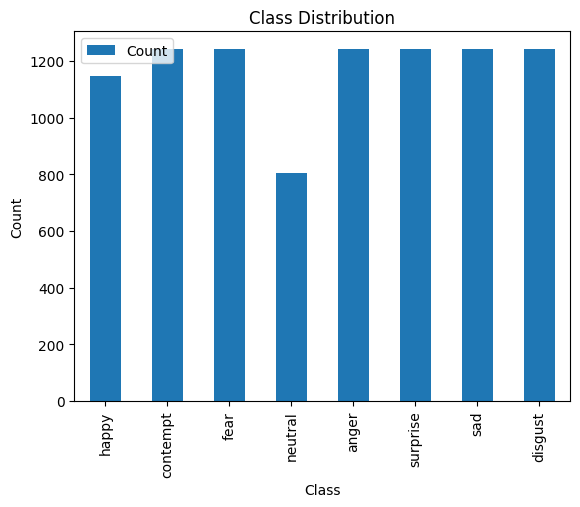

In [52]:
# Checl class count for training data
plot_class_count(train_dataloader)

In [53]:
# # Load the full dataset

data_etl = DataETL(data_dir, 42, number_of_images=None, balanced_data=None)

train_data, val_data, test_data = data_etl.transform_load(data_aug_transformation=train_aug_transform,
                              aug_class=['sad', 'disgust', 'contempt', 'fear', 'anger', 'neutral'])


Transformation started......
Extracting data......
Initialising custom data extraction......
Custom data extraction done......
Data extraction done......
Splitting data started.......
Splitting data completed.......
Applying data augmentation to training data......


Augmenting classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:43<00:00,  7.17s/it]


Train data count: 30141
Validation data count: 3069
Test data count: 3070
Transformation completed


The helper functions built so far will be made available from a python script in readiness for experimentation.